# BidMPH v2 Monitor <br> Curitiba

## Imports

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [54]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [55]:
CITY_ID = 4376
CITY_NAME = 'Curitiba'
ORDER_TYPE = 'auto_econom'

In [56]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [57]:
start_date = '2025-05-01'
end_date = '2025-06-20'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

df_total saved as Curitiba_total_bids.csv


df0 ('Before')

In [58]:
start_date = '2025-05-01'
end_date = '2025-05-19'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-05-01 00:00:17+00:00 
 to 2025-05-19 23:59:59+00:00
df0 saved as Curitiba_before_bids.csv


df1 ('Test')

In [59]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-20 00:00:14+00:00 
 to 2025-05-22 07:48:35+00:00
df1 saved as Curitiba_test_bids.csv


## Process Data

In [60]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [61]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

In [62]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [63]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

df1

In [64]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_28436/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [65]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

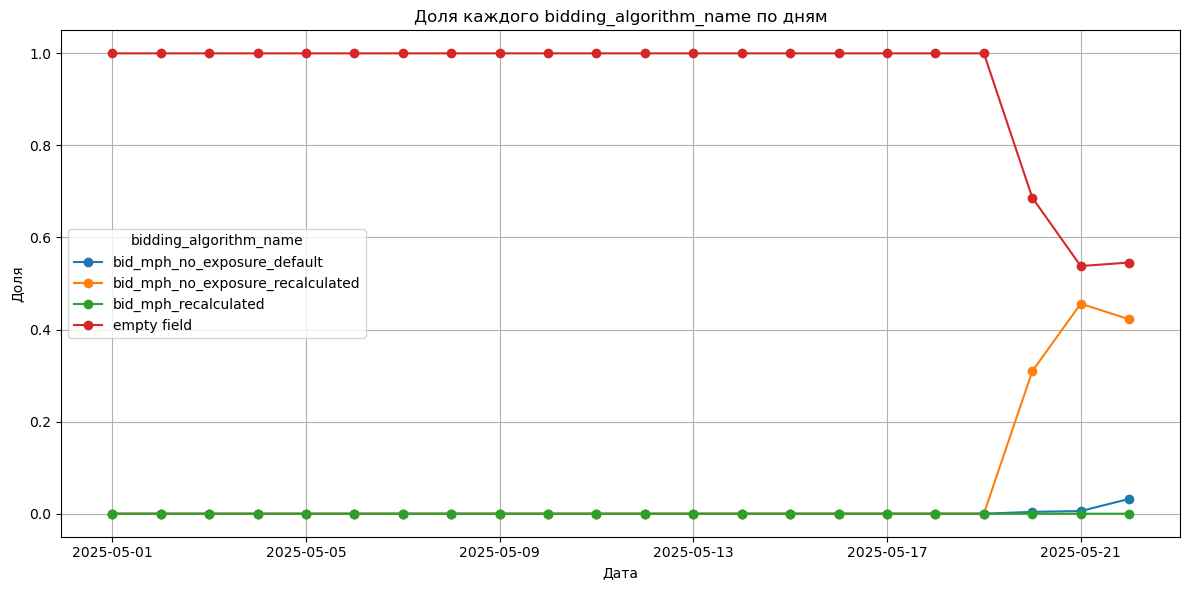

In [66]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [67]:
df0['bidding_algorithm_name'].unique()

array(['empty field'], dtype=object)

In [68]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=3)

In [69]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'empty field': 1.0}
Максимальное кол-во шагов:
10
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_10': 0.9248,
 'len_2': 0.0,
 'len_3': 0.0,
 'len_4': 0.0,
 'len_5': 0.0,
 'len_6': 0.0002,
 'len_7': 0.0002,
 'len_8': 0.0392,
 'len_9': 0.0356,
 'total': 1777293}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': 0.4,
                 'share': 0.0},
 'between_1_2': {'done_share': 0.6,
                 'share': 0.0},
 'between_2_3': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.2662,
                 'share': 0.1163},
 'match_second': {'done_share': 0.1661,
                  'share': 0.1922},
 'match_sp': {'done_share': 0.4736,
              'share': 0.1806},
 'match_third': {'done_share': 0.0941,
                 'share': 0.1833}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказ

In [70]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.18175956356098855 0.11629933837583337 0.19215852422757532 0.18333949438837602


df1

In [71]:
df1['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_recalculated',
       'bid_mph_no_exposure_default', 'bid_mph_recalculated'],
      dtype=object)

In [72]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=3)

In [73]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.007,
 'bid_mph_no_exposure_recalculated': 0.3865,
 'bid_mph_recalculated': 0.0,
 'empty field': 0.6065}
Максимальное кол-во шагов:
10
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_10': 0.9119,
 'len_2': 0.0,
 'len_3': 0.0,
 'len_4': 0.0,
 'len_5': 0.0,
 'len_6': 0.0002,
 'len_7': 0.0003,
 'len_8': 0.0474,
 'len_9': 0.0401,
 'total': 109028}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': nan,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'between_2_3': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.267,
                 'share': 0.1145},
 'match_second': {'done_share': 0.1629,
                  'share': 0.1938},
 'match_sp': {'done_share': 0.4782,
              'share': 0.1682},
 'match_third': 

In [74]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=3)

In [75]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.007,
 'bid_mph_no_exposure_recalculated': 0.3865,
 'bid_mph_recalculated': 0.0,
 'empty field': 0.6065}
Максимальное кол-во шагов:
10
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_10': 0.0214,
 'len_2': 0.4491,
 'len_3': 0.1311,
 'len_4': 0.1189,
 'len_5': 0.1364,
 'len_6': 0.0788,
 'len_7': 0.0331,
 'len_8': 0.0198,
 'len_9': 0.0114,
 'total': 70743}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': nan,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'between_2_3': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.2561,
                 'share': 0.1493},
 'match_second': {'done_share': 0.1499,
                  'share': 0.3347},
 'match_sp': {'done_share': 0.477,
              'share': 0.1991},
 'mat